In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
netflix_overall=pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")
netflix_overall.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
netflix_overall.count()

show_id         7787
type            7787
title           7787
director        5398
cast            7069
country         7280
date_added      7777
release_year    7787
rating          7780
duration        7787
listed_in       7787
description     7787
dtype: int64

In [5]:
netflix_shows=netflix_overall[netflix_overall['type']=='TV Show']


In [6]:
netflix_movies=netflix_overall[netflix_overall['type']=='Movie']

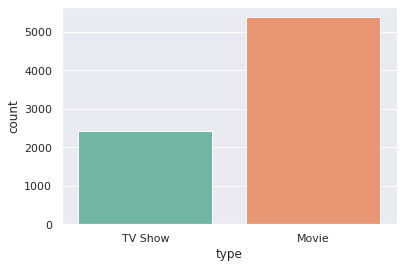

In [7]:
sns.set(style="darkgrid")
ax = sns.countplot(x="type", data=netflix_overall, palette="Set2")

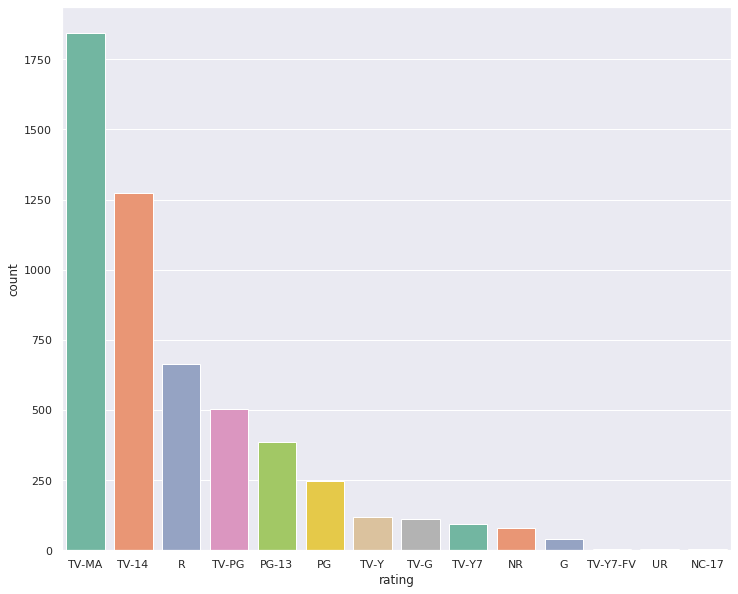

In [9]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="rating", data=netflix_movies, palette="Set2", order=netflix_movies['rating'].value_counts().index[0:15])

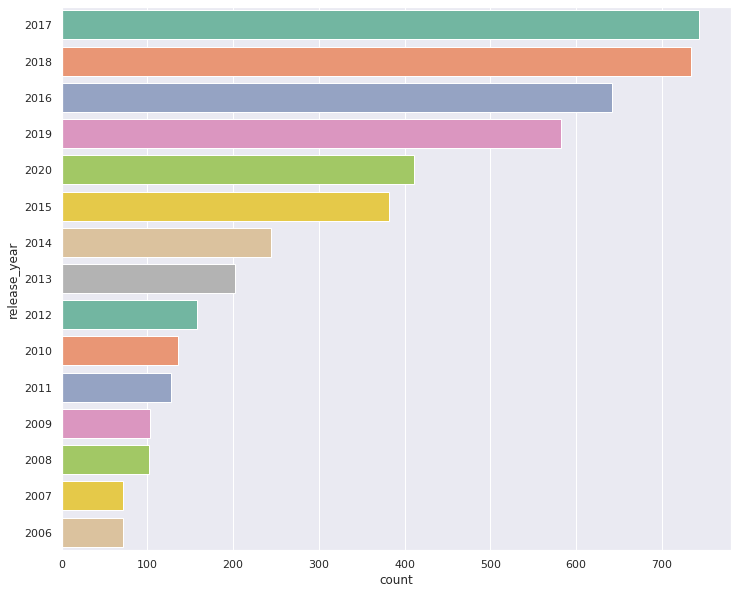

In [15]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y="release_year", data=netflix_movies, palette="Set2", order=netflix_movies['release_year'].value_counts().index[0:15])

So, 2017 was the year when most of the movies were released.

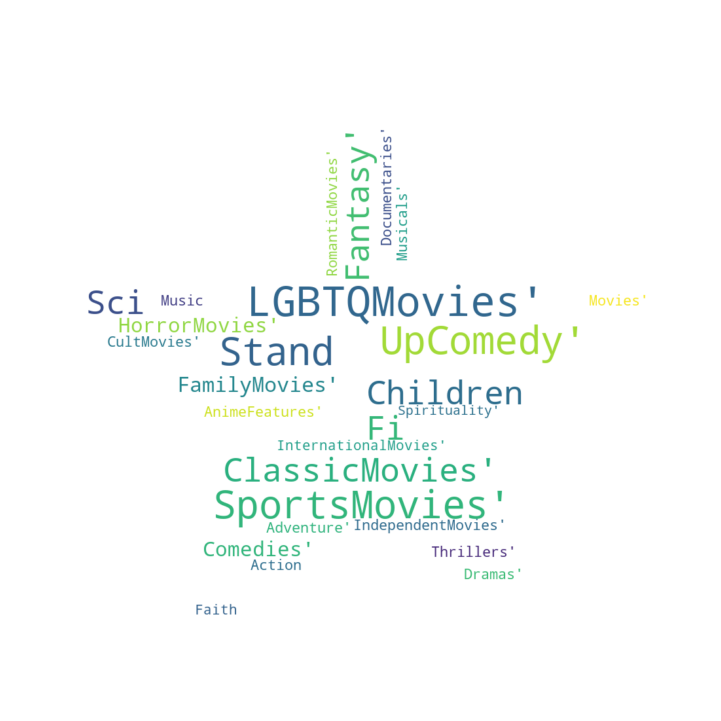

In [22]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

text = list(set(gen))
plt.rcParams['figure.figsize'] = (13, 13)

#assigning shape to the word cloud
mask = np.array(Image.open('../input/masks/star.png'))
wordcloud = WordCloud(max_words=1000000,background_color="white",mask=mask).generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

Therefore, it is clear that international movies, dramas and comedies are the top three genres that have the highest amount of content on Netflix.

In [29]:
t=['title','no_of_seasons']
top=durations[t]

top=top.sort_values(by='no_of_seasons', ascending=False)

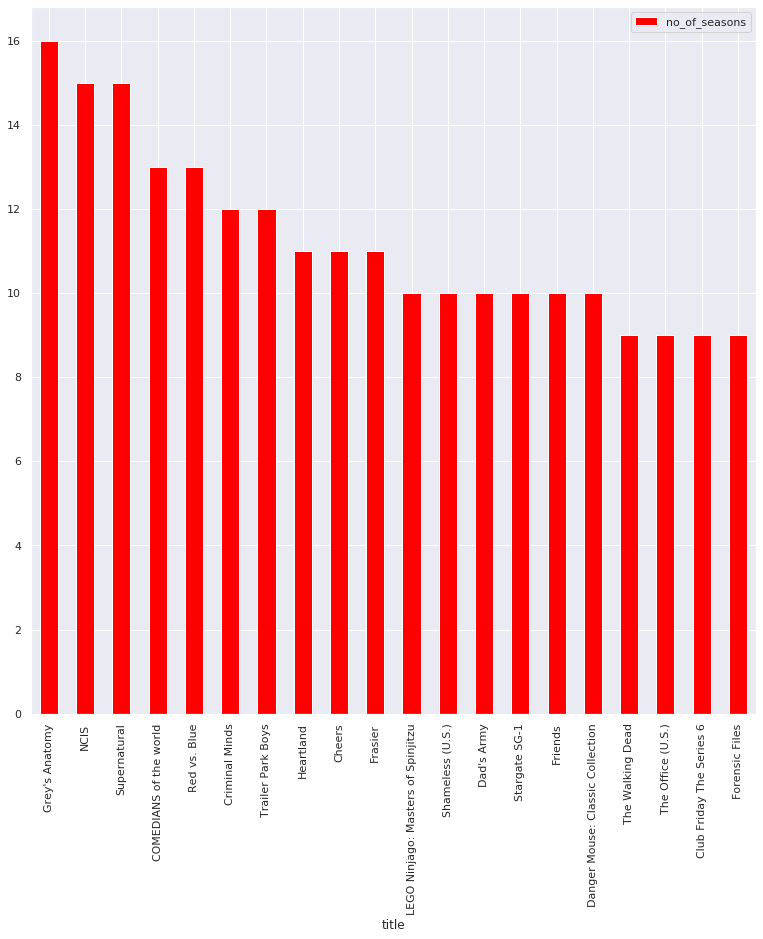

In [30]:
top20=top[0:20]
top20.plot(kind='bar',x='title',y='no_of_seasons', color='red')

# Recommendation System (Content Based)

The TF-IDF(Term Frequency-Inverse Document Frequency (TF-IDF) ) score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
netflix_overall['description'] = netflix_overall['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(netflix_overall['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape


(7787, 17905)

In [46]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [47]:
indices = pd.Series(netflix_overall.index, index=netflix_overall['title']).drop_duplicates()

In [48]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return netflix_overall['title'].iloc[movie_indices]

This recommendation is just based on the Plot.

In [49]:
get_recommendations('Peaky Blinders')

4692                    Our Godfather
4358                   My Stupid Boss
1807                              Don
6344                         The Fear
3219    Jonathan Strange & Mr Norrell
4953                Power Rangers Zeo
6783                       The Prison
6950                       The Tudors
6236                    The Con Is On
6585     The Legend of Michael Mishra
Name: title, dtype: object

In [50]:
get_recommendations('Mortel')

4858                  PILI Fantasy: War of Dragons
1920         Edgar Rice Burroughs' Tarzan and Jane
2159                             Figures of Speech
4314    My Entire High School Sinking Into the Sea
2188                                     FirstBorn
4994                                 Psychokinesis
608                                 At First Light
6958                          The Umbrella Academy
1267                                     Chamatkar
3864                              Maharakshak Devi
Name: title, dtype: object

It is seen that the model performs well, but is not very accurate.Therefore, more metrics are added to the model to improve performance.

Content based filtering on the following factors:
* Title
* Cast
* Director
* Listed in
* Plot

In [51]:
filledna=netflix_overall.fillna('')
filledna.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...


Cleaning the data - making all the words lower case

In [52]:
def clean_data(x):
        return str.lower(x.replace(" ", ""))

In [53]:
features=['title','director','cast','listed_in','description']
filledna=filledna[features]

In [54]:
for feature in features:
    filledna[feature] = filledna[feature].apply(clean_data)
    
filledna.head(2)

,title,director,cast,listed_in,description
0,3%,,"joãomiguel,biancacomparato,michelgomes,rodolfo...","internationaltvshows,tvdramas,tvsci-fi&fantasy",inafuturewheretheeliteinhabitanislandparadisef...
1,7:19,jorgemichelgrau,"demiánbichir,héctorbonilla,oscarserrano,azalia...","dramas,internationalmovies","afteradevastatingearthquakehitsmexicocity,trap..."


Creating a "soup" or a "bag of words" for all rows.

In [55]:
def create_soup(x):
    return x['title']+ ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

In [56]:
filledna['soup'] = filledna.apply(create_soup, axis=1)


In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(filledna['soup'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [58]:
filledna=filledna.reset_index()
indices = pd.Series(filledna.index, index=filledna['title'])

In [59]:
def get_recommendations_new(title, cosine_sim=cosine_sim):
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return netflix_overall['title'].iloc[movie_indices]

In [60]:
get_recommendations_new('PK', cosine_sim2)

100                            3 Idiots
6585       The Legend of Michael Mishra
552                   Anthony Kaun Hai?
2571                             Haapus
5377                              Sanju
5954                   Taare Zameen Par
1261                    Chal Dhar Pakad
1271                    Chance Pe Dance
1831                            Dostana
1988    EMI: Liya Hai To Chukana Padega
Name: title, dtype: object

In [61]:
get_recommendations_new('Peaky Blinders', cosine_sim2)

2419                                   Giri / Haji
6374                   The Frankenstein Chronicles
6693                         The Murder Detectives
3692                                        Loaded
3412                                 Kiss Me First
2616                                  Happy Valley
2381                                      Get Even
2846    How to Live Mortgage Free with Sarah Beeny
2886                                 I AM A KILLER
3013                      Inside the Criminal Mind
Name: title, dtype: object

In [62]:
get_recommendations_new('The Hook Up Plan', cosine_sim2)

2168                                        Find Yourself
1590                                       Dancing Angels
4024                     Melodies of Life - Born This Way
3676                                        Little Things
1435    Club Friday To Be Continued - My Beautiful Tomboy
5219                                           Rishta.com
38                                    แผนร้ายนายเจ้าเล่ห์
294                                  Accidentally in Love
720                                     Bangkok Bachelors
1463                                      College Romance
Name: title, dtype: object

Hence, more accurate predictions are obtained.